<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/ionq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **IonQ with Cirq**

##### *Libraries and Setup*

In [ ]:
!pip install cirq-ionq -q

In [ ]:
import cirq_ionq # https://docs.ionq.com/sdks/cirq
import cirq      # https://quantumai.google/cirq/hardware/ionq/circuits

In [ ]:
print(f"Cirq version: {cirq.__version__}")
print(f"Cirq-IonQ version: {cirq_ionq.__version__}")

Cirq version: 1.6.1
Cirq-IonQ version: 1.6.1


In [ ]:
import json
import pickle
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import files
from collections import Counter
import matplotlib.pyplot as plt
import cirq_ionq.ionq_exceptions as ionq_exceptions

##### *Connect to IonQ and Devices*

In [ ]:
# Connect to IonQ Service and Secret Manager for Token
from google.colab import userdata
api_token = userdata.get('ionq-quantum')
service = cirq_ionq.Service(api_key=api_token)

In [ ]:
# Check Available Backends (Simulators and QPUs) --> https://cloud.ionq.com/backends/qpus

headers = {"Authorization": f"apiKey {'ionq-quantum'}"}
r = requests.get("https://api.ionq.co/v0.3/backends", headers=headers)
if r.status_code == 200:
    for i, b in enumerate(r.json(), 1):
        qt = b.get('average_queue_time', 0)
        print(f"\n{i}. {b['backend'].upper()}\n └── Type: {'QPU' if 'qpu' in b['backend'] else 'Simulator'}\n └── Status: {b['status'].upper()}\n └── Qubits: {b['qubits']}\n └── Average Queue Time: {f'{qt/3600:.1f} hours' if qt > 3600 else f'{qt/60:.1f} minutes' if qt > 60 else f'{qt} seconds'}" + (''.join([f"\n └── Available Noise Models: {', '.join(b['noise_models'])}" if 'noise_models' in b else "", f"\n └── Characterization: Available" if 'characterization_url' in b else "", f"\n └── DEGRADED SERVICE" if b.get('degraded', False) else ""])))
else: print(f"Backend check failed: {r.status_code}\nError details: {r.text}")


1. QPU.HARMONY
 └── Type: QPU
 └── Status: RETIRED
 └── Qubits: 11
 └── Average Queue Time: 0 seconds

2. QPU.ARIA-1
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 25
 └── Average Queue Time: 3981.8 hours
 └── Characterization: Available

3. QPU.ARIA-2
 └── Type: QPU
 └── Status: RETIRED
 └── Qubits: 25
 └── Average Queue Time: 0 seconds
 └── Characterization: Available

4. SIMULATOR
 └── Type: Simulator
 └── Status: AVAILABLE
 └── Qubits: 29
 └── Average Queue Time: 0 seconds
 └── Available Noise Models: aria-1, harmony, ideal

5. QPU.FORTE-1
 └── Type: QPU
 └── Status: AVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 50198.5 hours
 └── Characterization: Available

6. QPU.FORTE-ENTERPRISE-1
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 11979.8 hours
 └── Characterization: Available


In [ ]:
# https://quantumai.google/cirq/hardware/ionq/calibrations
calibration = service.get_current_calibration()

In [ ]:
print(calibration.fidelities())

In [ ]:
print(calibration.timings())

##### *Use Case*

**Use Case: Two-Qubit Entangled [Bell State](https://en.wikipedia.org/wiki/Bell_state) Preparation $|\Phi^+\rangle$**

* Start with two qubits, $q_0$ and $q_1$, both initialized to the $|0\rangle$ state, creating the state **$|00\rangle$**.

* Hadamard gate puts $q_0$ into a **superposition**, meaning it is equally likely to be measured as $|0\rangle$ or $|1\rangle$.
  * Hadamard on the first qubit $q_0$:  $|00\rangle \xrightarrow{H \otimes I} \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes |0\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$
  * The state becomes $\frac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$

* CNOT gate for **Entanglement** (using $q_0$ as the control and $q_1$ as the target): CNOT flips $q_1$ only if $q_0$ is $|1\rangle$  
    * If $q_0$ is $|0\rangle$, $q_1$ stays $|0\rangle$ (path $|00\rangle \to |00\rangle$).
    * If $q_0$ is $|1\rangle$, $q_1$ flips from $|0\rangle$ to $|1\rangle$ (path $|10\rangle \to |11\rangle$).
    * $\frac{1}{\sqrt{2}}(|00\rangle + |10\rangle) \xrightarrow{\text{CNOT}} \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) = |\Phi^+\rangle$
    * The state becomes $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) = |\Phi^+\rangle$

This final state, $|\Phi^+\rangle$, is a maximally *entangled Bell state* $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$ because measuring $q_0$ instantly determines $q_1$:with each outcome ('00' or '11') occurring with a $\mathbf{50\%}$ probability.
* The amplitude for $|00\rangle$ is $1/\sqrt{2}$. The probability $P('00') = |1/\sqrt{2}|^2 = 0.5$
* The amplitude for $|11\rangle$ is $1/\sqrt{2}$. The probability $P('11') = |1/\sqrt{2}|^2 = 0.5$

In [ ]:
# Define Circuit - Two-Qubit Bell state Preparation |Φ+⟩
q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.measure(q0, q1, key='x'))
print(circuit)

0: ───H───@───M('x')───
          │   │
1: ───────X───M────────


##### *Simulations*

In [ ]:
# Theoretical Calculation (Exact probability distribution based on state vector simulation)
def calculate_exact_noiseless_probabilities(circuit: cirq.Circuit) -> dict:

    # 1. Circuit Preparation and Measurement Removal
    """
    The purpose of a state vector simulation is to find the final quantum state before
    the measurement operation collapses it. Removing the terminal cirq.measure gate ensures
    the simulator provides the final superposition state |Φ⁺⟩
    """
    circuit_without_measurements = cirq.drop_terminal_measurements(circuit)

    # 2. State Vector Simulation
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit_without_measurements)
    final_state_vector = result.final_state_vector

    exact_counts = {}

    # 3. Probability and Count Calculation
    for i, amplitude in enumerate(final_state_vector):
        probability = np.abs(amplitude)**2
        count = round(probability * 100)  # Convert to counts for number of shots ('repetitions=')

    # 4. Result Mapping
        if count > 0:
            exact_counts[i] = count  # Use integer key like {0: 50, 3: 50}
    return exact_counts
theoretical_prediction = calculate_exact_noiseless_probabilities(circuit)

print("--- Theoretical Count Distribution ---")
print(f"Counter({theoretical_prediction})")
theoretical_counter = Counter(theoretical_prediction) # mock counter object to match format

# Store results for later comparison
with open('theoretical_result.pkl', 'wb') as f:
    pickle.dump(theoretical_counter, f)

--- Theoretical Count Distribution ---
Counter({0: 50, 3: 50})


In [ ]:
# Noiseless simulation
result = service.run(
    circuit=circuit,
    target="simulator",
    repetitions=100,
    name="Noiseless Cirq Simulation")
print(result.histogram(key='x'))
print(result)
with open('noiseless_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({3: 53, 0: 47})
x=1101101100010001011111001101111100111001101101101110001000110010100101000000011111101001100110100110, 1101101100010001011111001101111100111001101101101110001000110010100101000000011111101001100110100110


In [ ]:
# Noisy simulation
# https://docs.ionq.com/guides/simulation-with-noise-models
result = service.run(
    circuit=circuit,
    target="simulator",
    repetitions=100,
    name="Noisy Cirq Simulation",
    extra_query_params={"noise": {"model": "forte-1"}})
print(result.histogram(key='x'))
print(result)
with open('noisy_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({0: 56, 3: 43, 2: 1})
x=0100101101100001110001000100001001101010011000010011010001101101100100100001010110110101111010011000, 0100101101100001110001000100001001101010011000010011010001101101100100100001010110110101111000011000


In [ ]:
# Quantum Simulation
# (https://docs.ionq.com/guides/qpu-submission-checklist)
job = service.create_job(
    circuit=circuit,
    target="qpu.forte-1", # forte-enterprise-1, aria-1
    repetitions=100,
    name="QPU Cirq Simulation")
print(job.job_id())
print(job.status())

019a7d6c-a0fb-779b-9340-8795a9a2f1c0
submitted


In [ ]:
# See job queue: https://cloud.ionq.com/jobs
job_id = "019a7d6c-a0fb-779b-9340-8795a9a2f1c0"
print(job.status())

completed


In [ ]:
# Retrieve a job
#job_id = "019a7d6c-a0fb-779b-9340-8795a9a2f1c0"
#job = service.get_job(job_id)

# Get the first result from the list
results_list = job.results()
result = results_list[0].to_cirq_result()  # Access first element
print(result.histogram(key='x'))
# Save results into file
with open('quantum_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({0: 55, 3: 43, 1: 1, 2: 1})


##### *Results and Interpretation*


RESULTS:
 State Binary  Theory  Noiseless  Noisy  Quantum
     0     00      50         47     56       55
     1     01       0          0      0        1
     2     10       0          0      1        1
     3     11      50         53     43       43



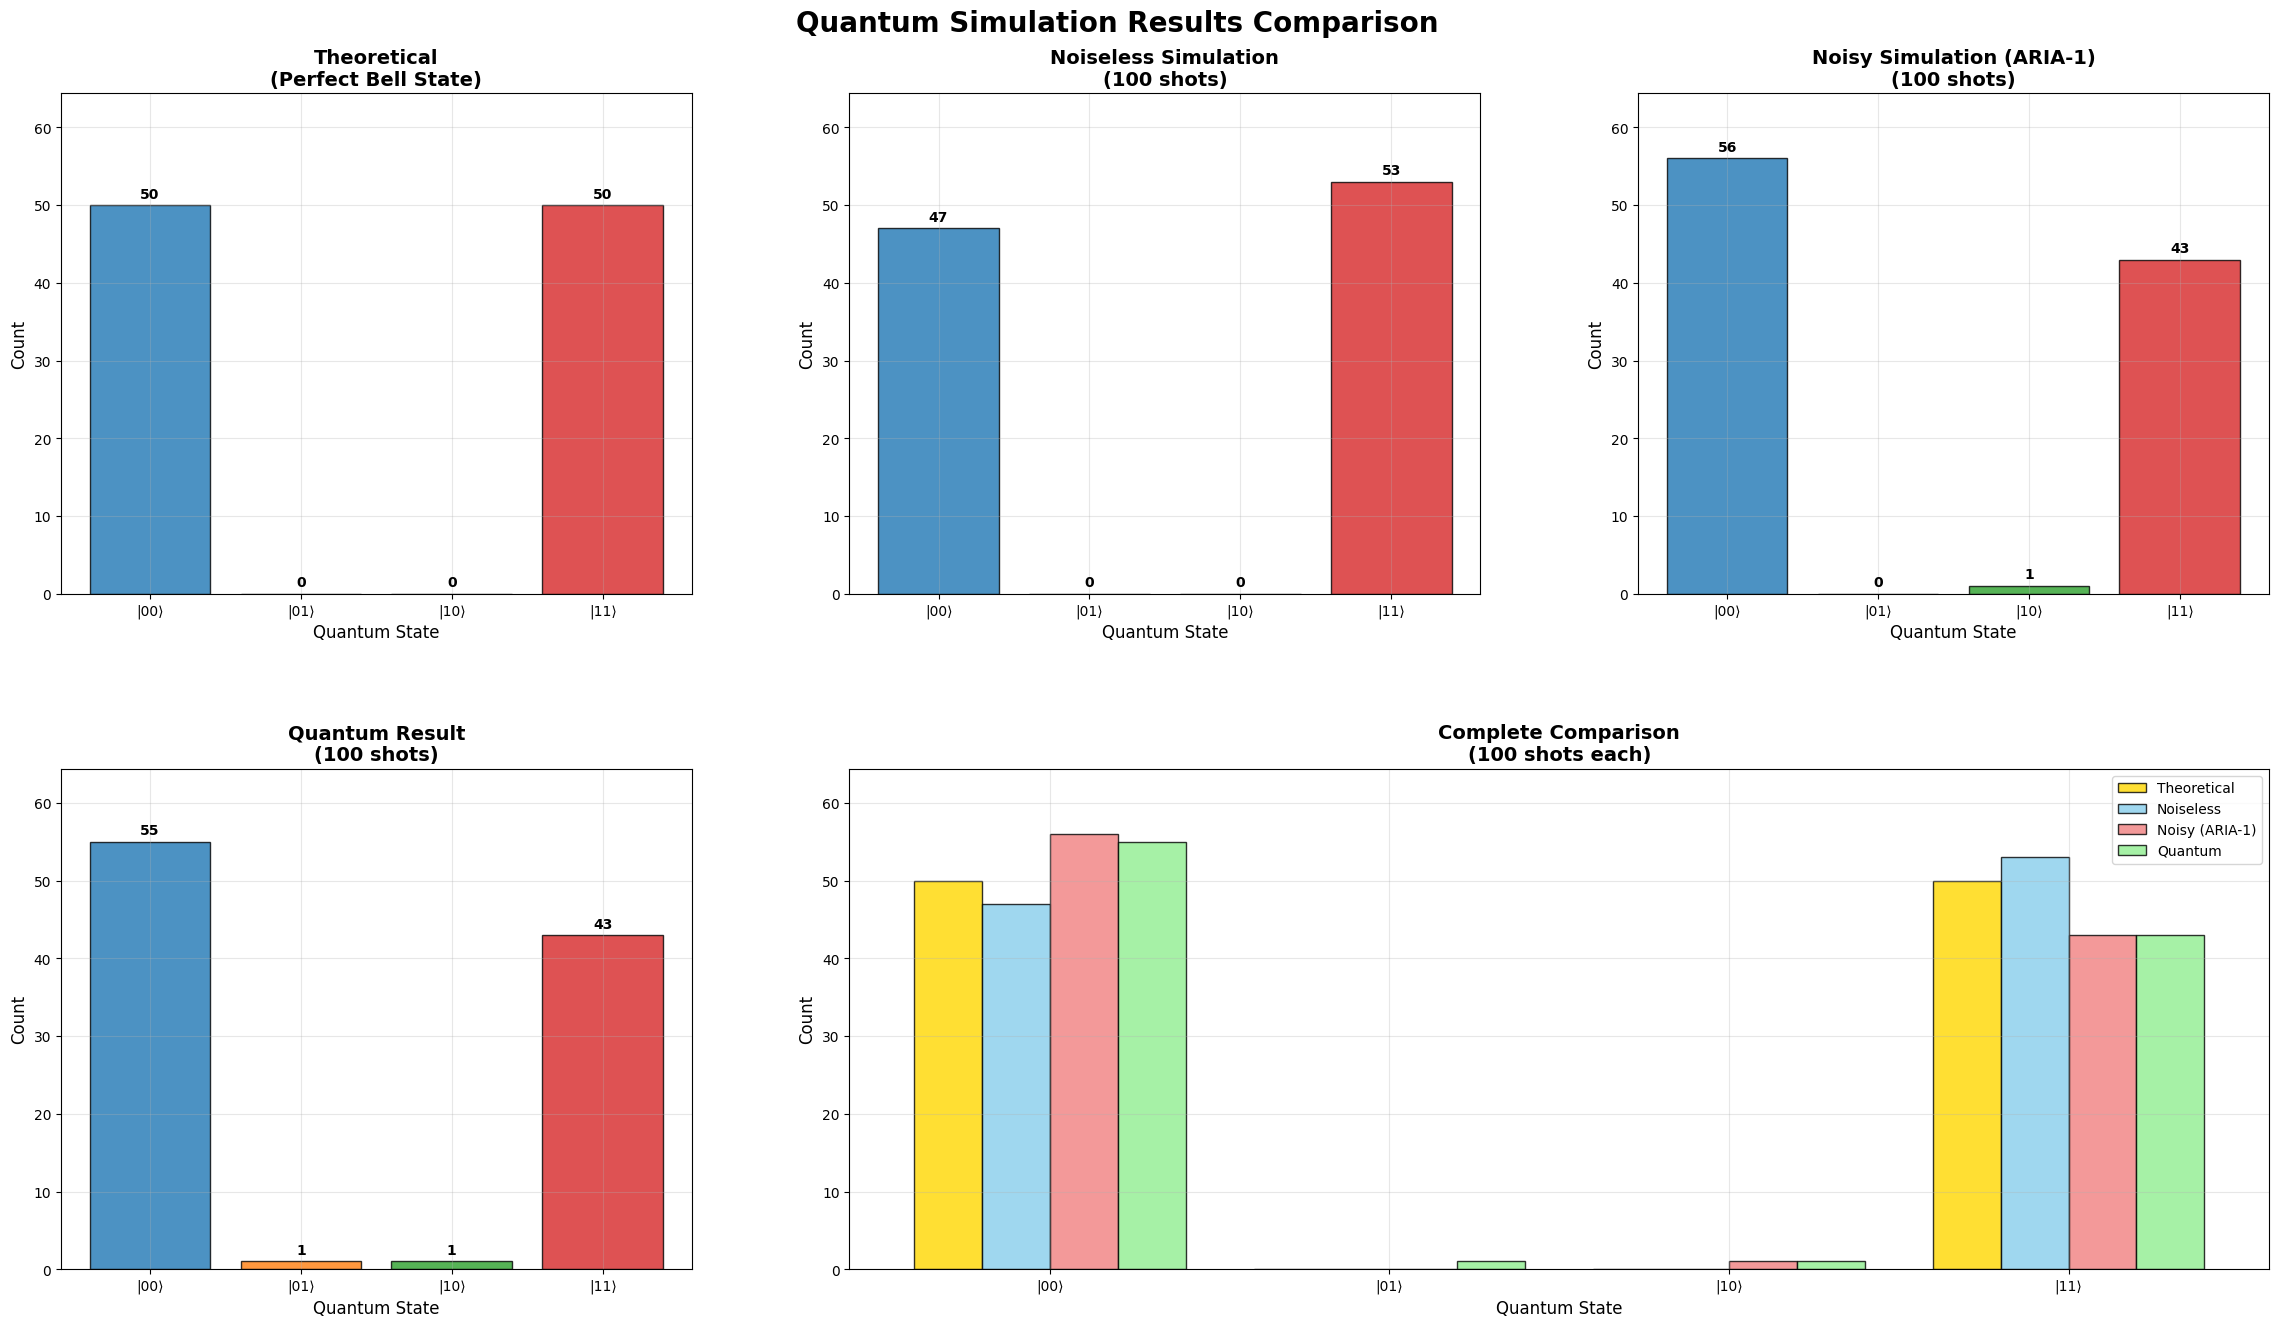

In [ ]:
# @title Comparison of Results
data = {}
for name in ['noiseless', 'noisy', 'theoretical', 'quantum']:
    with open(f'{name}_result.pkl', 'rb') as f:
        result = pickle.load(f)
        data[name] = result.histogram(key='x') if hasattr(result, 'histogram') else result

# Create comparison DataFrame
states = range(4)
comparison_df = pd.DataFrame({
    'State': states,
    'Binary': [format(s, '02b') for s in states],
    'Theory': [data['theoretical'].get(s, 0) for s in states],
    'Noiseless': [data['noiseless'].get(s, 0) for s in states],
    'Noisy': [data['noisy'].get(s, 0) for s in states],
    'Quantum': [data['quantum'].get(s, 0) for s in states]
})

print("\nRESULTS:\n" + "="*50)
print(comparison_df.to_string(index=False))
print("="*50 + "\n")

# Plotting
fig = plt.figure(figsize=(24, 14))
fig.suptitle('Quantum Simulation Results Comparison', fontsize=20, fontweight='bold', y=0.98)

state_labels = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plot_configs = [
    (1, 'Theory', 'Theoretical\n(Perfect Bell State)'),
    (2, 'Noiseless', 'Noiseless Simulation\n(100 shots)'),
    (3, 'Noisy', 'Noisy Simulation (ARIA-1)\n(100 shots)'),
    (4, 'Quantum', 'Quantum Result\n(100 shots)')
]

max_count = comparison_df[['Theory', 'Noiseless', 'Noisy', 'Quantum']].max().max()

# Individual plots
for idx, col, title in plot_configs:
    ax = plt.subplot(2, 3, idx)
    bars = ax.bar(state_labels, comparison_df[col], color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlabel('Quantum State', fontsize=12)
    ax.set_ylim(0, max_count * 1.15)
    ax.grid(True, alpha=0.3)

    # Add count labels
    for bar, count in zip(bars, comparison_df[col]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_count*0.01,
                f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Comparison plot
ax5 = plt.subplot(2, 3, (5, 6))
x = np.arange(4)
width = 0.2
plot_data = [
    ('Theory', 'Theoretical', 'gold'),
    ('Noiseless', 'Noiseless', 'skyblue'),
    ('Noisy', 'Noisy (ARIA-1)', 'lightcoral'),
    ('Quantum', 'Quantum', 'lightgreen')
]

for i, (col, label, color) in enumerate(plot_data):
    ax5.bar(x + (i-1.5)*width, comparison_df[col], width, label=label,
            color=color, alpha=0.8, edgecolor='black')

ax5.set_title('Complete Comparison\n(100 shots each)', fontsize=14, fontweight='bold')
ax5.set_ylabel('Count', fontsize=12)
ax5.set_xlabel('Quantum State', fontsize=12)
ax5.set_xticks(x)
ax5.set_xticklabels(state_labels)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)
ax5.set_ylim(0, max_count * 1.15)

plt.subplots_adjust(left=0.06, bottom=0.08, right=0.98, top=0.92, wspace=0.25, hspace=0.35)
plt.show()